In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [22]:
# Load trained models
resnet_model = tf.keras.models.load_model("/content/resnet50_augmented.keras")
efficientnet_model = tf.keras.models.load_model("/content/efficientnet_model.keras")
mobilenet_model = tf.keras.models.load_model("/content/mobilenet_model.keras")

In [23]:
import zipfile

with zipfile.ZipFile("fruit_subset_100.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/fruit_subset_100")

In [24]:
# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/fruit_subset_100",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32,
)

class_names = val_ds.class_names
num_classes = len(class_names)


Found 500 files belonging to 5 classes.
Using 100 files for validation.


In [25]:
# Get true labels
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true_binarized = label_binarize(y_true, classes=range(num_classes))

In [26]:
# Get predictions
y_pred_resnet = resnet_model.predict(val_ds)
y_pred_effnet = efficientnet_model.predict(val_ds)
y_pred_mobile = mobilenet_model.predict(val_ds)

3/4 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step 

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


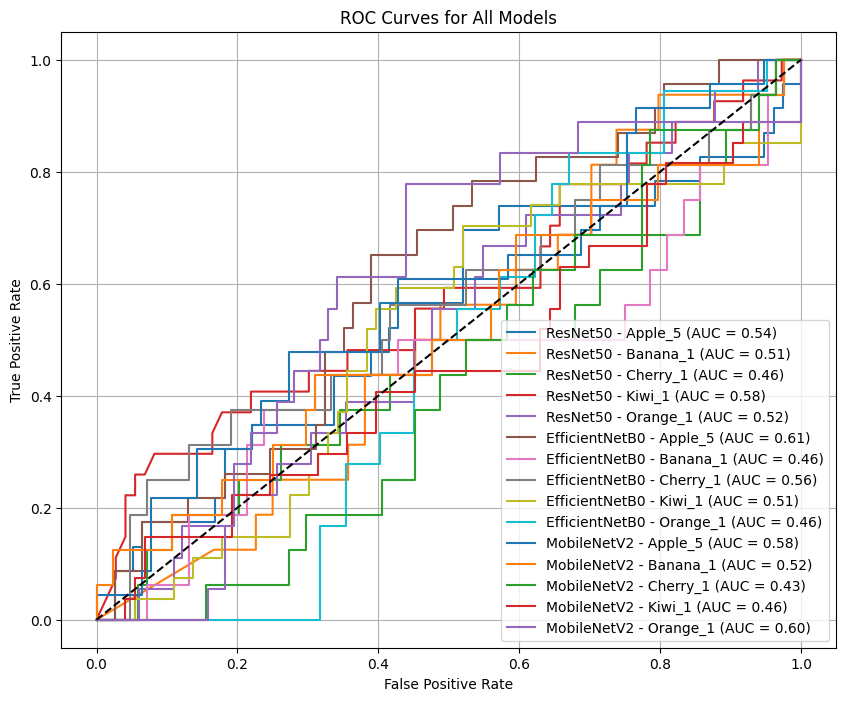

In [27]:
# Plotting function
def plot_roc(y_true_bin, y_pred, label):
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} - {class_names[i]} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(10, 8))
plot_roc(y_true_binarized, y_pred_resnet, "ResNet50")
plot_roc(y_true_binarized, y_pred_effnet, "EfficientNetB0")
plot_roc(y_true_binarized, y_pred_mobile, "MobileNetV2")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


In [28]:
import collections

# Re-extract y_true from val_dS
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)

# Count number of samples per class
counter = collections.Counter(y_true)
print("Validation class distribution:")
for idx, count in sorted(counter.items()):
    print(f"Class {class_names[int(idx)]}: {count} samples")

Validation class distribution:
Class Apple_5: 23 samples
Class Banana_1: 16 samples
Class Cherry_1: 16 samples
Class Kiwi_1: 27 samples
Class Orange_1: 18 samples


##Report

To evaluate the performance of different transfer learning models, we trained ResNet50, EfficientNetB0, and MobileNetV2 on a fruit image classification task with five classes. ROC curves were generated to compare their ability to distinguish between classes on the validation set. While none of the models demonstrated consistently strong performance across all classes, EfficientNetB0 stood out with the highest AUC scores on three classes (Apple_5, Cherry_1, and Banana_1), achieving a maximum AUC of 0.61. MobileNetV2 performed best on Orange_1 (AUC = 0.60), and ResNet50 only showed relatively better performance on Kiwi_1 (AUC = 0.58). These results suggest that EfficientNetB0 offers the most balanced and reliable performance for this dataset and will be selected as the preferred baseline for future model enhancements.